### Validation figure [transect]
#### - This is an adaptation of Fig. 3. I am making a temperature transect north-south through the slope  with ispycnals overlaid and comparing that to WOA18 climatology. 

In [247]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cftime
import glob,os
import matplotlib.colors as col
import xarray.ufuncs as xu
import gsw
import pandas as pd

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from glob import glob     #or else you get an error when trying to load the WOA files

##not sure why this is here
from matplotlib.cm import ScalarMappable

# set to your figure directory location:
#figdir = '/g/data/v45/akm157/figures/Antarctic_tides_fixed/temp_transect_movie/'

In [248]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45303/status,
Dashboard: /proxy/45303/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34743,Workers: 7
Dashboard: /proxy/45303/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39797,Total threads: 2
Dashboard: /proxy/44777/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:44061,


### LOAD MODEL DATA

### 2004-2018 to compare with seals

In [249]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
cycle3 = '01deg_jra55v140_iaf_cycle3'
##initially I calculated the model just for 2012, but after having a look on what sort of data the seals had, I decided to do all months from 2004-2018,
## so we would be covering the same period on both
first_year = '2004'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# set this to the rough region of interest:
lon_slice  = slice(-258, -248)
lat_slice  = slice(-67.5, -61)

In [250]:
# get temp and salt to calculate lines:
temp = cc.querying.getvar(cycle3,'temp',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly') - 273.15
temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

salt = cc.querying.getvar(cycle3,'salt',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22392009541440 and this is thread id 22389039556352.
Exception closing connection <sqlite3.Connection object at 0x145c57ff93f0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/pool/b

In [251]:
temp_4_yt_ocean=temp

#### Plot map of chosen transect

In [5]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
temp_slice = temp.sel(st_ocean=400,method='nearest').mean('time')
temp_slice = temp_slice.load()

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

Text(0, 0.5, 'Latitude ($^\\circ$)')

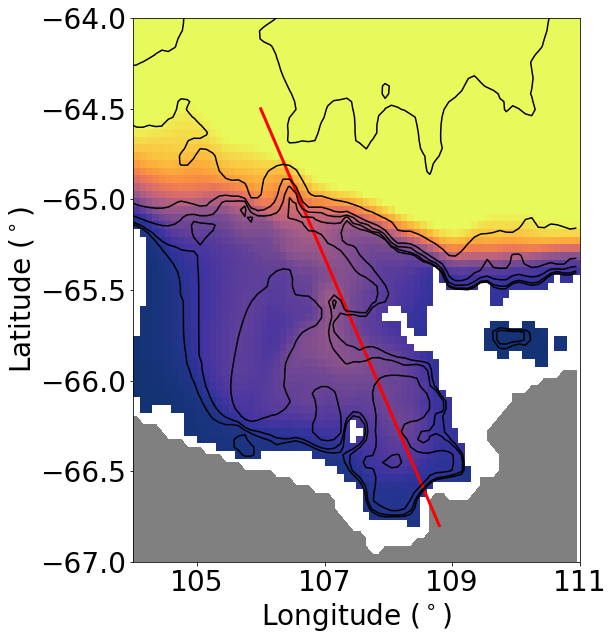

In [6]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -66.8
lat1=  -64.5
lon0 = -250.2
lon1 = -253 #-254

fontsize=28

fig=plt.figure(figsize=(10,10))
ax0=plt.subplot(1,1,1)  
# plot temperature:
plt.pcolormesh(temp_slice.xt_ocean,temp_slice.yt_ocean,temp_slice, cmap=cmocean.thermal,
              vmin=-2,vmax=0)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = 18,labelpad=5)
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

#figdir = '/home/581/ns3783/Scripts/Figures/New_codes_CFD/Figures'
#filestr = figdir+'/Fig2_map.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [7]:
#temp

### extract nearest points along transect 

In [8]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yt_ocean = temp.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')

# Extract temp and salt along transect:
temp_transect = temp.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect = salt.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect*0 + temp_transect.st_ocean
lat_array = temp_transect*0 + temp_transect.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)
sigma0 = gsw.sigma0(salt_abs,temp_transect)
# convert back to xarray for multiplying later:
sigma0 = xr.DataArray(sigma0,
                      coords = [temp_transect.time, temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['time','st_ocean','yt_ocean'])

In [9]:
# load data before plotting:
sigma0 = sigma0.load()
temp_transect = temp_transect.load()


In [10]:
# averaging data to get a year product
sigma0=sigma0.mean('time')
temp_transect=temp_transect.mean('time')

#### LOAD SEALS 

In [55]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-255, -247)
lat_slice  = slice(-75.5,-60)

In [56]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [57]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

In [58]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

## Select out profiles in correct region:

#### Improvements on this figure: take out winter profiles, sort profiles 
#### Fix it in a way they don't go much shallower than 400m. 

In [59]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/jk72/ns3783/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>104).where(lon<114).where(lat<-60).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 13.6 s, sys: 1.36 s, total: 15 s
Wall time: 14.7 s


In [60]:
np.shape(WAP_FileList)

(58,)

In [61]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:

nprofiles = 29496 # tested with one run / so this is all good. I know this is the right number for this dataset
ndepth = 1000 #although I have downloaded the profiles with no interpolation, some might have been interpolated because it doesn't run with less than 1000 levels
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
sal = np.zeros((nprofiles,ndepth))

lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
#date_obs = np.zeros((nprofiles)) 
year_obs = np.zeros((nprofiles))
month_obs = np.zeros((nprofiles))

profile_count = 0

file_count = 1
for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    juld = profile_data.JULD
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        temp_profile = profile_data.TEMP_ADJUSTED[profile]
        sal_profile = profile_data.PSAL_ADJUSTED[profile]
        if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
            # check the dive reached at least 200 dbar:
            pres_profile = profile_data.PRES_ADJUSTED[profile]
            if pres_profile.max() > 200:
                date = np.append(date,profile_data.JULD[profile])
                #date_obs[profile_count] = date[profile]
                year_obs[profile_count] = profile_data.JULD[profile].dt.year #this is an add on to lock months and years separately
                month_obs[profile_count] = profile_data.JULD[profile].dt.month
                # save profile:
                lat_obs[profile_count] = lat[profile]
                lon_obs[profile_count] = lon[profile]
                # find depth of profile/all levels:
                nlevels = len(profile_data.PRES_ADJUSTED[profile])
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                sal[profile_count,:nlevels] = sal_profile
                
                profile_count += 1
    file_count += 1

CPU times: user 2min 46s, sys: 11.9 s, total: 2min 58s
Wall time: 2min 43s


## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [128]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(sal,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [129]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [130]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [159]:
depth = np.arange(0, 5709, 77)
sal_interp = np.zeros((nprofiles, len(depth)))
temp_interp = np.zeros((nprofiles, len(depth)))
for i in range(nprofiles):
    # Get the actual depth values of the profile
    actual_depth = z[i, :]
    # Get the actual salinity and temperature values
    actual_sal = sal[i, :]
    actual_temp = temp_conservative[i, :]
    # Interpolate the salinity and temperature values along the new depth levels
    sal_interp[i, :] = np.interp(depth, actual_depth, actual_sal)
    temp_interp[i, :] = np.interp(depth, actual_depth, actual_temp)

In [160]:
print(np.size(depth))
print(np.size(sal_interp))
print(np.size(temp_interp))
print(np.size(lon_obs))
print(np.size(lat_obs))
print(np.size(date))

75
2212200
2212200
29496
29496
1


In [161]:
np.max(st_ocean)

<xarray.DataArray 'st_ocean' ()>
array(5709.44287109)

### INTERPOLATE TO THE MODEL Z GRID

In [167]:
def interpolate_to_model_grid(depth_obs, sal_obs, temp_obs, depth_model):
    """
    Interpolate salinity and temperature from observation depth levels to model depth levels.
    
    Parameters:
    -----------
    depth_obs : array_like
        1-D array of depths of the observation data.
    sal_obs : array_like
        2-D array of salinity values for each observation profile and depth level.
    temp_obs : array_like
        2-D array of temperature values for each observation profile and depth level.
    depth_model : array_like
        1-D array of depths of the model grid.
    
    Returns:
    --------
    sal_interp : array_like
        2-D array of salinity values interpolated onto the model grid.
    temp_interp : array_like
        2-D array of temperature values interpolated onto the model grid.
    """
    # Create a function to interpolate the depth of the observation data onto the model grid
    f_interp_depth = interp1d(depth_obs, depth_model, bounds_error=False, fill_value='extrapolate')
    depth_obs_model = f_interp_depth(depth_obs)
    
    # Interpolate salinity and temperature onto the new depth grid
    sal_interp = np.zeros((sal_obs.shape[0], depth_model.shape[0]))
    temp_interp = np.zeros((temp_obs.shape[0], depth_model.shape[0]))
    
    for profile in range(sal_obs.shape[0]):
        f_interp_sal = interp1d(depth_obs_model, sal_obs[profile, :], bounds_error=False, fill_value='extrapolate')
        f_interp_temp = interp1d(depth_obs_model, temp_obs[profile, :], bounds_error=False, fill_value='extrapolate')
        sal_interp[profile, :] = f_interp_sal(depth_model)
        temp_interp[profile, :] = f_interp_temp(depth_model)
    
    return sal_interp, temp_interp

In [168]:
temp_transect

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 55)>
array([[        nan,         nan,         nan, ..., -0.84891516,
        -0.85187167, -0.8497758 ],
       [        nan,         nan,         nan, ..., -0.8483718 ,
        -0.8513654 , -0.84918195],
       [        nan,         nan,         nan, ..., -0.84916013,
        -0.85203695, -0.8497616 ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    xt_ocean  (yt_ocean) float64 -250.2 -250.2 -250.3 ... -252.8 -252.9 -252.9
  * yt_ocean  (yt_ocean) float64 -66.79 -66.75 -66.71 ... -64.59 -64.55 -64.5
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [169]:
st_ocean = temp_transect.st_ocean
depth_obs = depth
depth_model = st_ocean
sal_obs=sal_interp
temp_obs=temp_interp

In [170]:
print(np.size(depth_obs))
print(np.size(sal_interp))
print(np.size(temp_interp))
print(np.size(depth_model))


75
2212200
2212200
75


In [171]:
sal_interp, temp_interp = interpolate_to_model_grid(depth_obs, sal_obs, temp_obs, depth_model)

### SAVE DATA IN XRRAYS

In [186]:
temp_interp = xr.DataArray(temp_interp, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'seal profiles interpolated onto model depth grid')
sal_interp = xr.DataArray(sal_interp, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'seal profiles interpolated onto model depth grid')
lon_obs = xr.DataArray(lon_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs = xr.DataArray(lat_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of seal profiles')
month_obs = xr.DataArray(month_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'month of seal profiles')
year_obs = xr.DataArray(year_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'year of seal profiles')
date = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

ds = xr.Dataset({'temp_interp': temp_interp,'sal_interp': sal_interp, 'lon_obs':lon_obs,'lat_obs':lat_obs,'month_obs':month_obs,'year_obs':year_obs,'date':date})
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated_slope.nc'
ds.to_netcdf(outpath)

## Open saved seal data:

In [306]:
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated_slope.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
month_obs = profile_data.month_obs
year_obs = profile_data.year_obs
temp_interp = profile_data.temp_interp
sal_interp = profile_data.sal_interp
date = profile_data.date
st_ocean = temp_interp.st_ocean

# need to assign lat/lon coords for binning:
temp_interp = temp_interp.assign_coords({'lon':lon_obs,'lat':lat_obs,'time':year_obs})
sal_interp = sal_interp.assign_coords({'lon':lon_obs,'lat':lat_obs,'time':year_obs})

In [311]:
temp_interp

<xarray.DataArray 'temp_interp' (profile_number: 29496, st_ocean: 75)>
[2212200 values with dtype=float64]
Coordinates:
  * profile_number  (profile_number) int64 0 1 2 3 4 ... 29492 29493 29494 29495
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    lon             (profile_number) float64 70.64 71.08 71.68 ... 105.7 105.9
    lat             (profile_number) float64 -49.73 -50.01 ... -64.98 -64.97
    time            (profile_number) float64 ...

In [ ]:
# create empty DataArray
new = xr.DataArray(
    name='binned meop temperature data',
    dims=['xt_ocean', 'yt_ocean', 'st_ocean', 'year'],
    coords={'xt_ocean': lon, 'yt_ocean': lat, 'st_ocean': st_ocean, 'year': time}
)

# assign data from temp_interp to new DataArray
new = new.sel(xt_ocean=temp_interp.lon, yt_ocean=temp_interp.lat, st_ocean=temp_interp.st_ocean, year=temp_interp.time)

2023-04-08 15:22:44,110 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:22:48,043 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:22:49,923 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:22:54,989 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:22:58,038 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:23:03,004 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:23:14,353 - distributed.nanny - WARNING - Restarting worker
2023-04-08 15:23:33,392 - distributed.nanny - WARNING - Worker process still alive after 3.999995040893555 seconds, killing
2023-04-08 15:23:33,402 - distributed.nanny - WARNING - Worker process still alive after 3.9999994277954105 seconds, killing
2023-04-08 15:23:33,404 - distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing
2023-04-08 15:23:33,405 - distributed.nanny - WARNING - Worker process still alive after 3.9999977111816407 s